# UNIT I — Notebook 3: Distribution Analysis, Skewness & Transformations

## Objective
In Notebook 1–2 we:
- Understood the dataset
- Found missing BMI and imputed it
- Discovered that BMI missingness is informative (flag feature)

Now we answer a critical question:

> Do our numeric features look Gaussian (bell-shaped)?
> If not, are they skewed?  
> And if they are skewed, what transformation should we apply?

This notebook includes:
1. Gaussian vs skewed intuition (visually)
2. Outlier intuition (visually)
3. Log transformation (minimal maths)
4. Before vs After comparison (proofs)

No model training yet.


## 1) Reload Data (Clean State)

Rule: Each notebook must run independently.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

path = "healthcare-dataset-stroke-data.csv"
df = pd.read_csv(path)

TARGET_COL = "stroke"
df.shape


(5110, 12)

## 2) Prepare the Clean Numeric Column(s)

From earlier work:
- `bmi` has missing values
- We will create:
  - `bmi_imputed` (median-imputed)
  - `bmi_missing_flag` (1 if missing, else 0)

Important:
- We DO NOT overwrite raw BMI.
- We create new columns.


In [2]:
# BMI imputation + missing flag
df["bmi_missing_flag"] = df["bmi"].isna().astype(int)
bmi_median = df["bmi"].median()
df["bmi_imputed"] = df["bmi"].fillna(bmi_median)

# Confirm
df[["bmi", "bmi_missing_flag", "bmi_imputed"]].head()

,bmi,bmi_missing_flag,bmi_imputed
0,36.6,0,36.6
1,NaN,1,28.1
2,32.5,0,32.5
3,34.4,0,34.4
4,24.0,0,24.0


## 3) What is a Gaussian Distribution? (Beginner Intuition + Minimal Math)

### Intuition
A Gaussian (Normal) distribution is the classic "bell curve":
- Most values are near the center
- Fewer values as you move away
- Symmetric left and right

### Why do we care?
Some methods behave better when features are near-normal:
- Linear/Logistic regression optimization stability
- PCA (feature extraction)
- Distance-based methods (KNN, SVM) behave more predictably

Tree-based models care much less about normality.

### Minimal Math (only what matters)
A normal distribution is summarized by:
- Mean (μ): average
- Standard deviation (σ): spread

We are NOT proving normality here.
We are learning to *diagnose shape visually* and fix skewness.


## 4) Distribution Check (Before Any Transformation)

We will inspect these numeric features:
- age
- bmi_imputed
- avg_glucose_level

We will use:
- Histogram (shape)
- Boxplot (outliers)


In [3]:
num_features = ["age", "bmi_imputed", "avg_glucose_level"]
num_features

['age', 'bmi_imputed', 'avg_glucose_level']

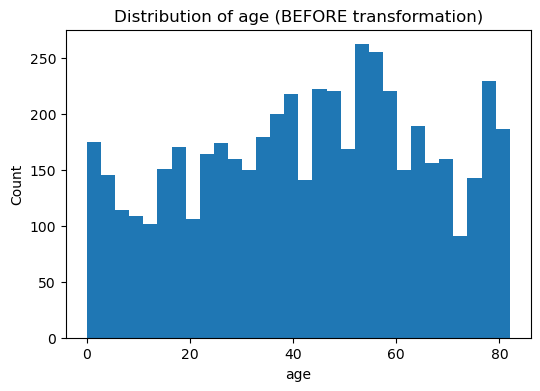

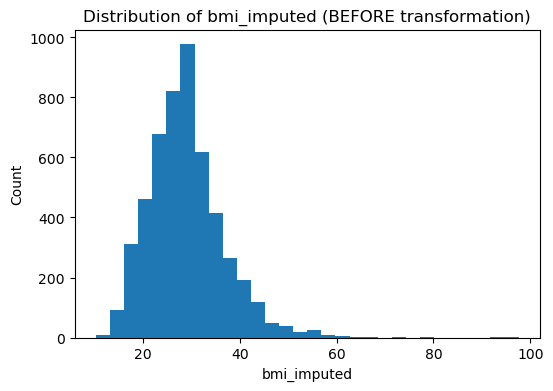

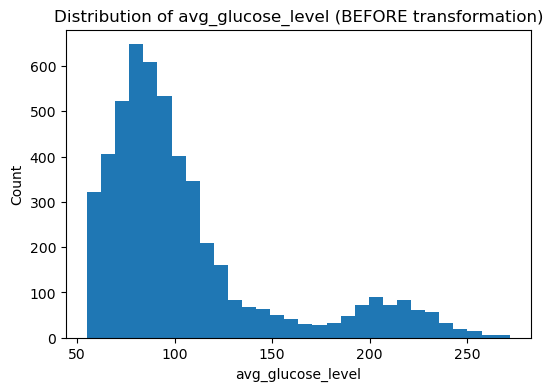

In [4]:
# Histograms (Before)
for col in num_features:
    plt.figure(figsize=(6,4))
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Distribution of {col} (BEFORE transformation)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


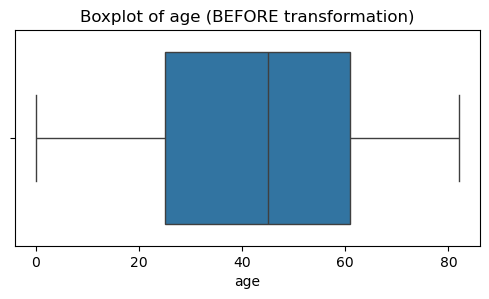

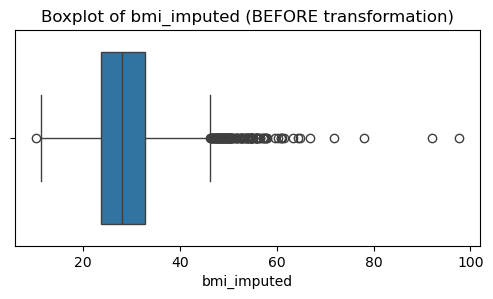

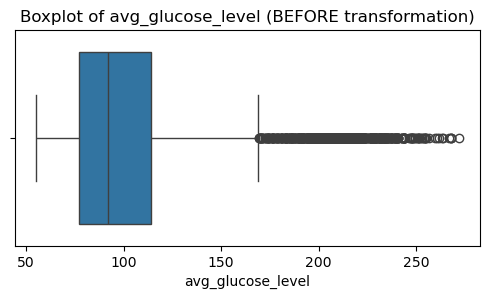

In [5]:
# Boxplots (Before)
for col in num_features:
    plt.figure(figsize=(6,2.8))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col} (BEFORE transformation)")
    plt.xlabel(col)
    plt.show()


## 5) Skewness — What It Means & Why It Matters

### Intuition
- Right-skewed: long tail to the right (few very large values)
- Left-skewed: long tail to the left (few very small values)

### Why skewness is a problem
- Mean becomes less representative (pulled by extreme values)
- Some algorithms struggle or become unstable
- Scaling alone does NOT fix skewness (it only fixes magnitude)

### Optional numeric check (light)
We compute skewness just to confirm what we see.


In [6]:
# Skewness values (confirmation, not primary)
skew_vals = df[num_features].skew(numeric_only=True).sort_values(ascending=False)
skew_vals


avg_glucose_level    1.572284
bmi_imputed          1.088187
age                 -0.137059
dtype: float64

## 6) Log Transformation (The One Transformation We Teach First)

### When to use log transform
Use log transform when:
- Feature is positive (or non-negative)
- Feature is right-skewed
- There are extreme high outliers
- You want to compress large values and reduce tail effect

### Formula (required math)
We use:
\[
x_{log} = \log(1 + x)
\]

Why `1 + x`?
- Because log(0) is undefined
- Adding 1 keeps zeros safe

### What log does (intuition)
- Small values change slightly
- Large values compress strongly
- Tail becomes shorter
- Distribution becomes more symmetric (often)

We will apply log transform to:
- `avg_glucose_level`
- `bmi_imputed`

We will NOT log-transform:
- Binary columns (0/1)
- Categorical encodings
- Missing flags

In [7]:
# Create log-transformed features (non-destructive)
df["log_avg_glucose_level"] = np.log1p(df["avg_glucose_level"])
df["log_bmi_imputed"] = np.log1p(df["bmi_imputed"])

df[["avg_glucose_level", "log_avg_glucose_level", "bmi_imputed", "log_bmi_imputed"]].head()


,avg_glucose_level,log_avg_glucose_level,bmi_imputed,log_bmi_imputed
0,228.69,5.436731,36.6,3.627004
1,202.21,5.314240,28.1,3.370738
2,105.92,4.672081,32.5,3.511545
3,171.23,5.148831,34.4,3.566712
4,174.12,5.165471,24.0,3.218876


## 7) Compare BEFORE vs AFTER (Histogram Proof)

We compare raw vs log-transformed distributions side-by-side (separate plots).


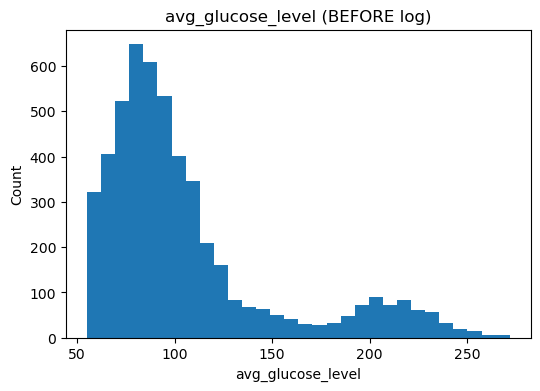

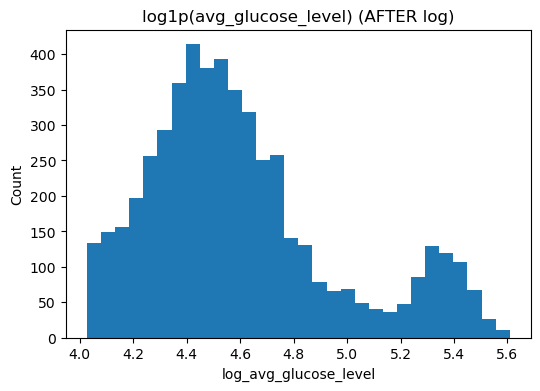

In [8]:
# Compare: avg_glucose_level
plt.figure(figsize=(6,4))
plt.hist(df["avg_glucose_level"], bins=30)
plt.title("avg_glucose_level (BEFORE log)")
plt.xlabel("avg_glucose_level")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df["log_avg_glucose_level"], bins=30)
plt.title("log1p(avg_glucose_level) (AFTER log)")
plt.xlabel("log_avg_glucose_level")
plt.ylabel("Count")
plt.show()


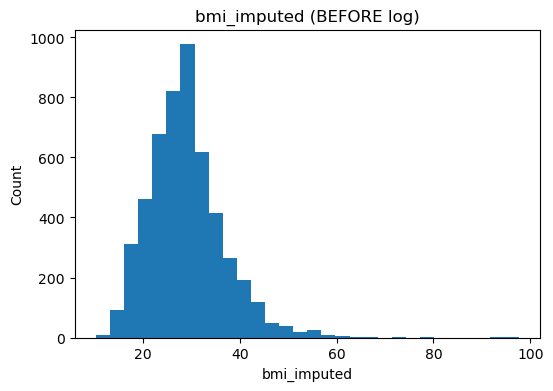

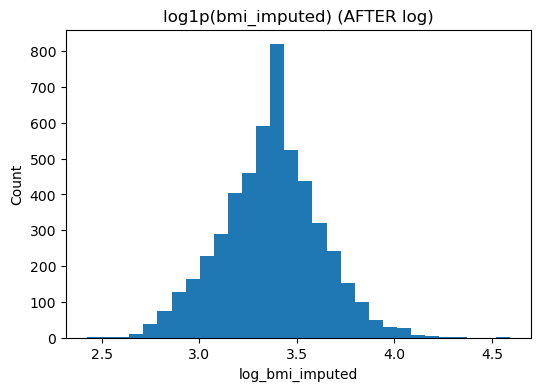

In [9]:
# Compare: bmi_imputed
plt.figure(figsize=(6,4))
plt.hist(df["bmi_imputed"], bins=30)
plt.title("bmi_imputed (BEFORE log)")
plt.xlabel("bmi_imputed")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df["log_bmi_imputed"], bins=30)
plt.title("log1p(bmi_imputed) (AFTER log)")
plt.xlabel("log_bmi_imputed")
plt.ylabel("Count")
plt.show()


## 8) Compare BEFORE vs AFTER (Boxplot Proof)

Boxplots show outliers clearly.
Log transform should reduce the impact of extreme values.


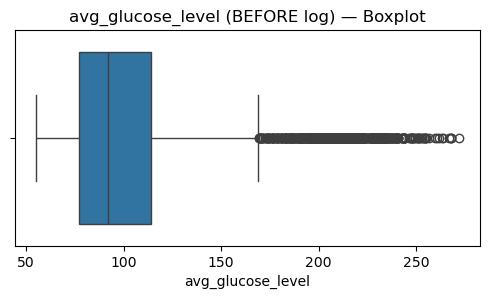

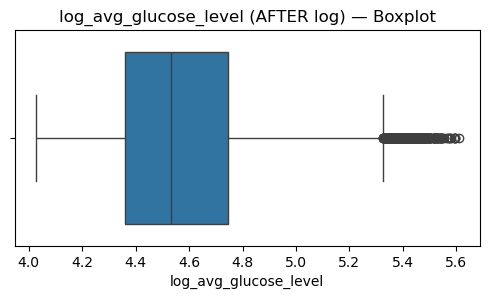

In [10]:
# Boxplots: avg_glucose_level
plt.figure(figsize=(6,2.8))
sns.boxplot(x=df["avg_glucose_level"])
plt.title("avg_glucose_level (BEFORE log) — Boxplot")
plt.xlabel("avg_glucose_level")
plt.show()

plt.figure(figsize=(6,2.8))
sns.boxplot(x=df["log_avg_glucose_level"])
plt.title("log_avg_glucose_level (AFTER log) — Boxplot")
plt.xlabel("log_avg_glucose_level")
plt.show()


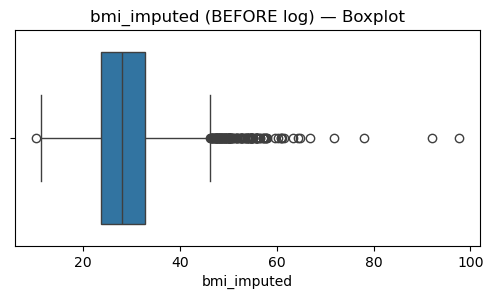

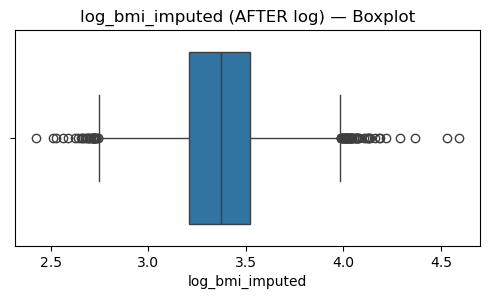

In [11]:
# Boxplots: bmi_imputed
plt.figure(figsize=(6,2.8))
sns.boxplot(x=df["bmi_imputed"])
plt.title("bmi_imputed (BEFORE log) — Boxplot")
plt.xlabel("bmi_imputed")
plt.show()

plt.figure(figsize=(6,2.8))
sns.boxplot(x=df["log_bmi_imputed"])
plt.title("log_bmi_imputed (AFTER log) — Boxplot")
plt.xlabel("log_bmi_imputed")
plt.show()


## 9) Quick Summary Table (Before vs After Skewness)

We compute skewness again to quantify improvement.
This is still light math.

Goal:
- Right-skew should reduce after log.


In [12]:
before_skew = df[["avg_glucose_level", "bmi_imputed"]].skew()
after_skew = df[["log_avg_glucose_level", "log_bmi_imputed"]].skew()

pd.DataFrame({
    "before_skew": before_skew,
    "after_skew": after_skew
})


,before_skew,after_skew
avg_glucose_level,1.572284,NaN
bmi_imputed,1.088187,NaN
log_avg_glucose_level,NaN,0.889470
log_bmi_imputed,NaN,0.029777


## 10) Decision: What Columns Will We Use Moving Forward?

We now have choices:
- Use raw columns (original)
- Use log-transformed columns (more stable)
- Keep both and let model decide later

Recommended for many models:
- `log_avg_glucose_level` instead of `avg_glucose_level`
- `log_bmi_imputed` instead of `bmi_imputed`

We will finalize this in preprocessing pipeline later.


In [13]:
recommended_numeric = ["age", "log_avg_glucose_level", "log_bmi_imputed"]
recommended_numeric


['age', 'log_avg_glucose_level', 'log_bmi_imputed']

## 11) Notebook 3 Summary

We learned:
1. How to visually diagnose Gaussian vs skewed distributions
2. Why skewness matters (mean distortion + algorithm stability)
3. Log transformation:
   - Formula: log(1 + x)
   - When to use it
4. Verified transformation effects using:
   - Histograms (shape)
   - Boxplots (outliers)
   - Skewness (confirmation)

We did NOT do scaling yet.

Next: Notebook 4 will cover:
- Standardization vs Normalization
- When to apply scaling
- Why scaling comes AFTER transformation